In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
nx = int(4717)
ny = int(2600)

Read bathymetry

In [3]:
x0 = 90
x1 = 325.83
y0 = -60
y1 = 70

In [4]:
bathymetry = np.fromfile('../data/bathymetry3min',dtype='float64')[2:]
                                                                              

bathymetry = bathymetry.reshape((ny,-1))

x = np.linspace(x0,x1, bathymetry.shape[1])
y = np.linspace(y0,y1, bathymetry.shape[0])
x, y = np.meshgrid(x, y)

Read Nami 2D  output

In [5]:
hmax = np.loadtxt('../tsunamilab/tlab2D',delimiter=',',skiprows=1).reshape((ny,-1))

harr = np.loadtxt('../tsunamilab/tlab2D (1)',delimiter=',',skiprows=1).reshape((ny,-1))

harrmasked = np.ma.masked_where(bathymetry<500,harr)

Pois locations

In [6]:
[21418,32411,51407,55012]

[21418, 32411, 51407, 55012]

In [7]:
pois={
    21414: [178.219,48.968],
    21419: [155.717,44.435],
    21401: [152.583,42.617],
    21418: [148.645,38.727],
    21413: [152.132,30.533],
    52403: [145.52,4.02],
    52406: [164.977,-5.307],
    55012: [158.453,-15.664],
    51425: [183.68,-9.517],
    51407: [203.455,19.57],
    46404: [231.267,45.853],
    46407: [231.168,42.682],
    46411: [232.933,39.333],
    46412: [239.437,32.492],
    43412: [253.03300000000002,16.045],
    43413: [259.91700000000003,11.012],
    32411: [269.12,4.953],
    32412: [273.626,-17.984],
    32413: [266.483,-7.406],
    32401: [286.579,-20.474],
}
darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403]# [21418,32411,51407,55012]
# darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403, 21418,32411,51407,55012]

In [8]:
dart_locations = np.array(list(pois.values()))

In [9]:
s = 10 #skip size
hmax_masked = np.ma.masked_where(bathymetry<10,hmax)

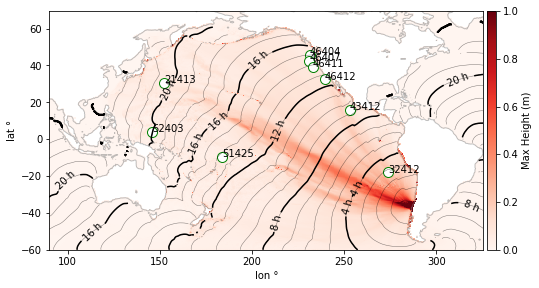

In [10]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

p = ax1.pcolormesh(x[::s,::s],y[::s,::s],hmax_masked[::s,::s],vmax=1,vmin=0, cmap=plt.cm.Reds)
divider = make_axes_locatable(ax1)

for  dart in darts_ids:
    
    [lon, lat] = pois[dart]
    ax1.scatter([lon],[lat],color='white',edgecolor='green',marker='o', s=100)
    ax1.annotate('%s'%dart, [lon+0.1,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harrmasked[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harrmasked[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')
f.savefig('energy2010.png',dpi=300,bbox_inches='tight')

# Time series

Read Nami time series

In [11]:
nami = pd.read_json('../tsunamilab/pois')

Read Easywave time series

In [12]:
ewave = pd.read_csv('../easyWave/eWave.poi.ssh', delim_whitespace=True)

Read DART buoys time series

In [13]:
darts = {}
for dart in darts_ids:
    darts[dart] = np.loadtxt('../data/tsunamiDART{}'.format(dart))

In [14]:
starts = {
    21413: 1200,
    32412: 150,
    43412: 550,
    46404: 900,
    46407: 850,
    46411:800,
    46412: 750,
    51425: 800,
    52403: 1250
}

In [15]:
group1 = [32412, 43412, 46412]
group2 = [46411, 46407, 46404]
group3 = [51425, 52403, 21413]
orderedBuoys = [32412, 46411, 51425, 43412, 46407, 52403, 46412, 46404, 21413]

In [16]:
for i, d in enumerate(orderedBuoys):
    print(i,d)

0 32412
1 46411
2 51425
3 43412
4 46407
5 52403
6 46412
7 46404
8 21413


In [17]:
yranges = {
    46411: [-0.05, 0.1],
    46404: [-0.1,0.1]
}

In [18]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

32412 6.5 7.0
46411 17.333333333333336 18.0
51425 17.333333333333336 18.0
43412 13.166666666666666 14.0
46407 18.166666666666664 19.0
52403 24.833333333333332 25.0
46412 16.5 17.0
46404 19.0 19.0
21413 24.0 24.0


/home/jose/gitrepos/tesis/venv/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


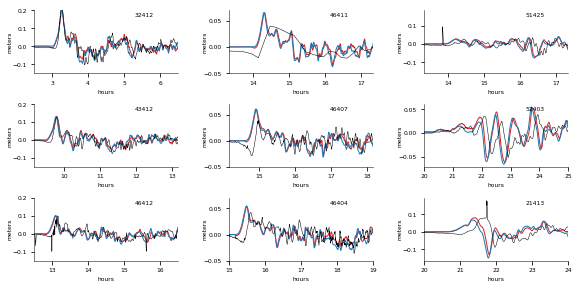

In [19]:
f = plt.figure(figsize=(12/1.5, 6/1.5))
for i, dart_number in enumerate(orderedBuoys):
    ax = f.add_subplot(3,3,i+1)
    
    ax.plot(ewave['Minute']/60., ewave[str(dart_number)],
            label='easywave',color='#d62728', linewidth=1)
    ax.plot(np.array(nami[dart_number].time)/60/60, nami[dart_number].surface,
            label='nami', linewidth=1)
    ax.plot(darts[dart_number][:,0]*24, darts[dart_number][:,1], 
            label='dart buoy', color='k',linewidth=0.5)

    
    xmin = min(starts[dart_number]/60, 20)
    xmax = min(starts[dart_number]/60+4,25)
    ax.set_xlim( xmin, xmax)
    ax.annotate('%s'%dart_number, [0.7,0.9], xycoords='axes fraction')
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    
    ax.spines['bottom'].set_linewidth(0.5)
    xticks = np.arange(np.ceil(xmin), np.ceil(xmax+0.5), 1, dtype=np.int)
    ax.set_xticks(xticks)
    if dart_number in group1:
        ax.set_ylim(-0.15,0.2)
        ax.set_yticks(np.arange(-0.1,0.2,0.1))
    elif dart_number in group2:
        ax.set_ylim(-0.05,0.07)
        ax.set_yticks(np.arange(-0.05,0.051,0.05))
    
        
    ax.set_xlabel('hours')
    ax.set_ylabel('meters')

    
f.tight_layout()
f.subplots_adjust(wspace=0.35)
f.savefig('timeseries2010.png',dpi=300, bbox_inches='tight')

32412 43412 46412: súper buen ajuste con las mediciones, en tiempo de arribo y peak, aunque se comienzan a desfasar con l 

luego se desfasan sistemáticamente, quedando siepmre un poco adelante, pero la forma en general y orden de magnitud de las olas está bien, la estimación de máximo también

